
# Analysing Airline Network 


*import libraries*

In [1]:
import csv
import networkx as nx 
import numpy as np 
import community 
import powerlaw 

%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import operator 
import collections
import sys
from tqdm import tqdm
import random

Load airline data. In the dataset, each line represent an edge. First two entries on a line represent the nodes (following IATA airport code). A directed graph is built here.

In [2]:
with open('airport_list.csv', 'rb') as file_handle:
    next(file_handle, '')  
    G = nx.read_edgelist(file_handle, delimiter=',', create_using=nx.DiGraph(), 
                         nodetype=str, encoding="utf-8")

## EDA on network data

**Network Statistics**
<br> A directed network the average degree is simply  $<k>= \frac{L}{N} $


In [3]:
N = G.order() #G.order(), gives number of nodes 
L = G.size() #G.size(), gives number of edges

avg_deg = float(L) / N #calculate average degree

#print out statistics
print("Nodes: ", N)
print("Edges: ", L)
print("Average degree: ", avg_deg)

Nodes:  3286
Edges:  39428
Average degree:  11.99878271454656


**In-degree and Out-degree** 

Distribution of airports will be in terms of in-coming and out-going flights. This is known as the node in-degree and out-degree (respectively) in networkx. 

In [4]:
in_degrees = G.in_degree()  # dictionary node:degree
out_degrees = G.out_degree()

# Example
print("Singapore routes in %d" % in_degrees['"SIN"']) #routes in of Changi, Singapore
print("Singapore routes out %d" % out_degrees['"SIN"']) #routes out Changi, Singapore


Singapore routes in 122
Singapore routes out 122


Plot the distribution of in-degree and out-degree for all airports, e.g., how many airports have an out-degree of 122, how many have and in-degree of 65. 

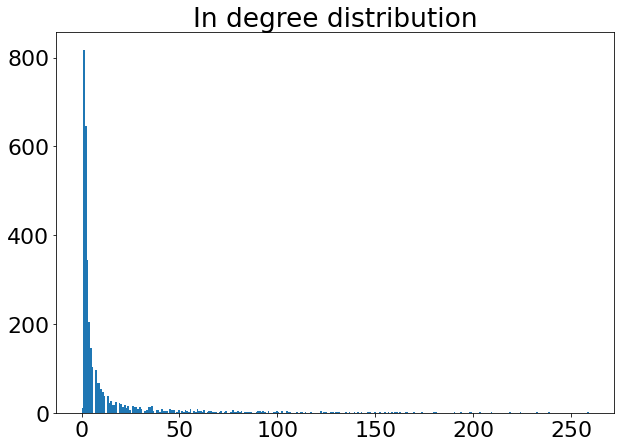

<ipython-input-5-17ecf37e7318>:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim((0, 1e3)) #set y axis limits


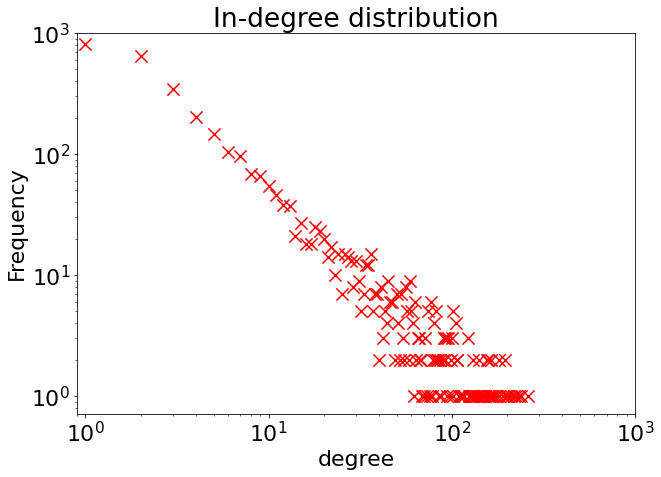

Calculating best minimal value for power law fit


Assuming nested distributions
C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\powerlaw.py:1818: RuntimeWarning: invalid value encountered in double_scalars
  R = R/sqrt(n*variance)


exponential nan, exponential 1.0
power_law 0.09687609348224271, lognormal 0.9228247941299103
exponential -3.9284438110018276, power_lab 8.549732094159882e-05
alpha = 1.8135330145787687
xmin = 5.0


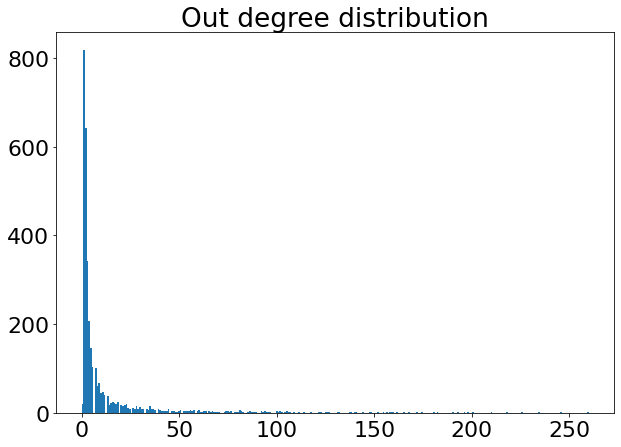

<ipython-input-5-17ecf37e7318>:53: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim((0, 1e3)) #set y axis limits


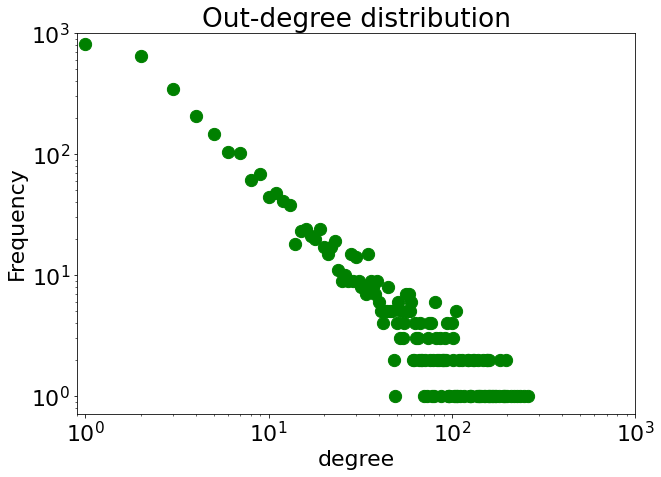

In [5]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees()).values(), bins=300, density=False)
plt.title('In degree distribution')
plt.savefig('in-degree.png')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_counts = dict(collections.Counter(dict(in_degrees()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_counts.keys(), in_degree_counts.values(), c='r', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data = np.array(list(in_degree_counts.values()),dtype=np.float32)
fit = powerlaw.Fit(data)

R, p = fit.distribution_compare('exponential','exponential',  normalized_ratio=True)
print("exponential {}, exponential {}".format(R, p))
R, p = fit.distribution_compare('power_law','lognormal',  normalized_ratio=True)
print("power_law {}, lognormal {}".format(R, p))
R, p = fit.distribution_compare('exponential','power_law',  normalized_ratio=True)
print("exponential {}, power_lab {}".format(R, p))

print("alpha = {}".format(fit.power_law.alpha))
print("xmin = {}".format(fit.power_law.xmin))

#Histogram of out-degrees
plt.hist(dict(out_degrees()).values(), bins=300, density=False)
plt.title('Out degree distribution')
plt.savefig('out-degree.png')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_counts = dict(collections.Counter(dict(out_degrees()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_counts.keys(), out_degree_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()


**Path Lengths in the Airline Network**
<br> So out of curiosity, what is the max number of flights one need to take from one end of the world to the other, i.e., the longest number of flights required to reach any place in the world!! We can also calculate the average path length, which indicates the average number of legs required to travel between different cities in the world.

<br> Average path length of graph G: $$l_G = \frac{\sum_{i \neq j} d(n_i, n_j)}{N(N-1)}$$ where $d(n_i, n_j)$ is the shortest path between nodes.
<br> Network diameter is the longest shortest path between any two nodes in the network. 

In [6]:
if not 'avg_path_length' in globals(): 
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G, n) 
        total += sum(path_length.values()) #total of all shortest paths from n
    
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path 
            max_path_length = max(path_length.values())         
    avg_path_length = total / (N*(N - 1)) #calculate average.

print("Average path length %f" % (avg_path_length)) 
print("Network Diameter %d" % (max_path_length)) 

Average path length 3.975508
Network Diameter 13


**Centrality**
<br> Which airports have the highest centrality?
- Betweenness centrality - which airport lies on most routes
- Closeness centrality - which airport is the shortest number of hops to all other airports
- Eigenvector centrality - which airport is connected to other important networks

Betweenness mean: 0.000910
1: ('"FRA"', 0.07592441094231539)
2: ('"ANC"', 0.06813434918554233)
3: ('"DXB"', 0.05706143873905378)
4: ('"LAX"', 0.055868791723451494)
5: ('"CDG"', 0.053783412879072616)
6: ('"PEK"', 0.04509497088741924)
7: ('"ORD"', 0.044388591632186274)
8: ('"YYZ"', 0.04140686254154214)
9: ('"AMS"', 0.0409890256121003)
10: ('"GRU"', 0.0403494428584058)


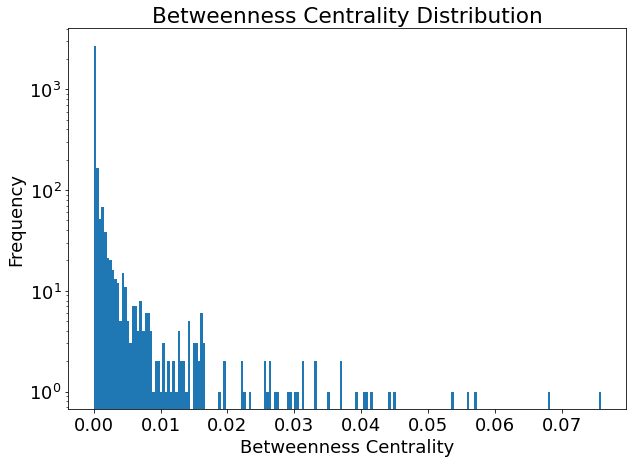

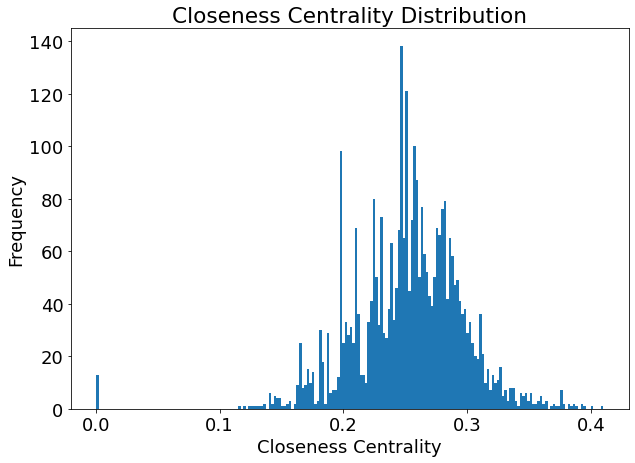

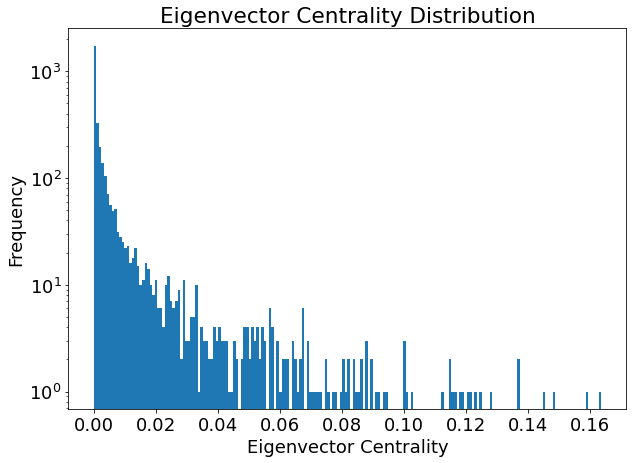

In [7]:
if not 'bet_cen' in globals(): #only calculate this if its not been calculated before
    bet_cen = nx.betweenness_centrality(G)
    clo_cen = nx.closeness_centrality(G)
    eig_cen = nx.eigenvector_centrality(G)

#Histogram of in-degrees
print("Betweenness mean: %f" % (np.array(list(bet_cen.values())).mean()))

#get a list of airports sorted by betweenness
airports_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 airports by betweenness
    print(str(x+1)+ ": " + str(airports_sorted_by_betweenness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(bet_cen.values(), bins=200, density=False) 
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Betweenness Centrality Distribution')
plt.show()

plt.hist(clo_cen.values(), bins=200, density=False) 
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Closeness Centrality Distribution')
plt.show()

plt.hist(eig_cen.values(), bins=200, density=False) 
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Eigenvector Centrality Distribution')
plt.show()

From the data, **'FRA'** (Frankfurt) lies in most routes. There are the usual busy airports, such as 'DXB' (Dubai) and 'CDG' (Paris) airports in the top 10. However, 'ANC' (Anchorage international airport) in Alaska, was a surprise number 2!

## Visualisation

**Network Visualisation** 
<br>
1. All the nodes (with spring_layout) and edges are visualised. 
2. A subset of nodes, is created, based on an out-degree greater than 180.

{'"FRA"': Text(0.01859484426677227, -0.026818349957466125, '"FRA"'),
 '"LGW"': Text(0.030815592035651207, -0.028110235929489136, '"LGW"'),
 '"AMS"': Text(0.02129126340150833, -0.01944981887936592, '"AMS"'),
 '"CDG"': Text(0.01767377369105816, -0.02147943526506424, '"CDG"'),
 '"DME"': Text(0.013940484263002872, -0.06431983411312103, '"DME"'),
 '"FCO"': Text(0.017586342990398407, -0.03271067142486572, '"FCO"'),
 '"ATL"': Text(0.043101727962493896, 0.03161345794796944, '"ATL"'),
 '"MUC"': Text(0.01923041045665741, -0.03214417025446892, '"MUC"'),
 '"PEK"': Text(-0.027822470292448997, -0.049264565110206604, '"PEK"'),
 '"ORD"': Text(0.037217188626527786, 0.02206648513674736, '"ORD"'),
 '"DFW"': Text(0.041204407811164856, 0.042839545756578445, '"DFW"'),
 '"DXB"': Text(-0.010664683766663074, -0.05632372945547104, '"DXB"'),
 '"DEN"': Text(0.04815690219402313, 0.06056967005133629, '"DEN"'),
 '"IST"': Text(0.007926310412585735, -0.05195997282862663, '"IST"'),
 '"BCN"': Text(0.03058980591595173, -

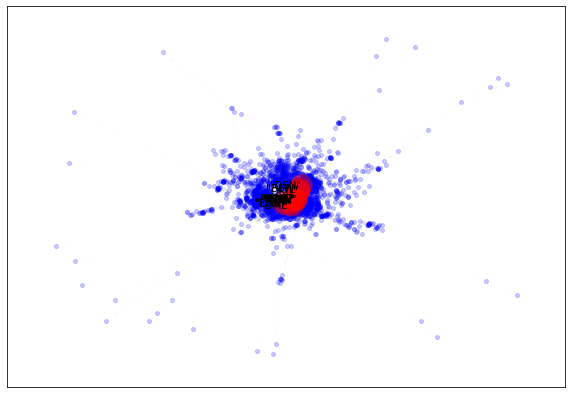

In [8]:
# import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

# create the layout
pos = nx.spring_layout(G)

# If you have graphviz installed you can try the following.
# pos=nx.graphviz_layout(G,prog='neato')

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G,pos,node_color='b',alpha=0.2,node_size=16)
nx.draw_networkx_edges(G,pos,alpha=0.005)

v = list(dict(out_degrees()).values())
# nodes_to_keep = [n for n in out_degrees if out_degrees[n] > 180]
nodes_to_keep = [n[0] for n in out_degrees if n[1] > 180]
# only keep nodes
G_s = G.subgraph(nodes_to_keep)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(G_s,pos,node_color='r',alpha=0.4,node_size=450)
# also the labels this time
nx.draw_networkx_labels(G_s,pos,font_size=10,font_color='k',horizontalalignment='right')


**Modularity**
<br>
Identify partitions within the network and then colour nodes based on which partition they lie in. 

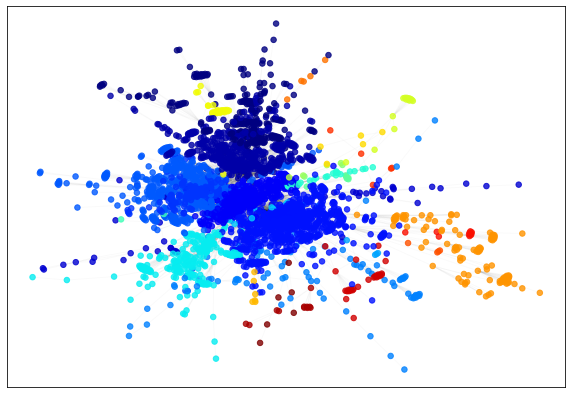

In [9]:
# To do this, the network first has to be undirected.
G_ud = G.to_undirected() 

nx.transitivity(G_ud)
# find modularity
part = community.best_partition(G_ud)
mod = community.modularity(part, G_ud)

# plot, color nodes using community structure
values = [part.get(node) for node in G_ud.nodes()]
pos = nx.spring_layout(G_ud,iterations=100,k=100.0/N) #k indicates separation strength, bigger=> further apart nodes
nx.draw_networkx_nodes(G_ud,
                       pos,
                       cmap=plt.get_cmap('jet'),
                       node_color=values, 
                       node_size=30, 
                       label=None,
                       alpha=0.8)
nx.draw_networkx_edges(G_ud,
                       pos,
                       alpha=0.02)

plt.savefig('airport_cluster.png')
plt.show()

**Export output to file**

In [10]:
nx.write_graphml(G, "airports.graphml") #export the directed network
nx.write_gml(G,"airports.gml") 
nx.write_gexf(G, "airports.gexf") #write in gephi format

**Visualise in Gephi**

NetworkX does not have great visualisation capabilities built in. It is better to export the file and use **Gephi**. Below is the airports in Fruchterman Reingol layout. Nodes in green have higher degree (or connections to other airports). 

<img src="airline_fruchterman_reingold.png" alt="Airports in Fruchterman Reingol layout" width="400"/>

Below is the clustered airports in Fruchterman Reingol layout. Nodes are coloured based on their own communities/clusters.

<img src="airline_modularity_2.png" alt="Clustered airports in Fruchterman Reingol layout" width="400"/>

## Robustness
<br>
Understanding the robustness against *failures* or *attacks* of this network (i.e., when nodes or edges are removed), is important if the systems need to be engineered or protected. 

Failure is defined as the random removal of a mode (and its connected edges). Attach is when a node (and its connected edges) is targeted for removed based on some measure (e.g., max degree, max betweenness, etc.). 

The attacks (or failures) are made one-by-one to the network until we remove a fraction $f$ of all the nodes $N$ in the original network. Then, a number of network parameters to gauge their impact as a function of $f$, is measured.
    
1. $S_c$, fraction of remaining nodes in the largest component
2. $<l>_c$, average path length of largest component
3. $D_c$, Diameter of the largest component 

*defining failure and attack functions*

In [11]:
def fail(G): # remove a random node from the graph G
    n = random.choice(list(G.nodes()))  #pick a random node
    G.remove_node(n) # remove that random node, attached edges automatically
    
def attack_degree(G): #remove node with maximum degree
    degrees = G.degree() # get dictonary where key is node id, value is degree
    max_degree = max(dict(degrees()).values()) # find maximum degree value from all nodes
    max_keys = [k for k,v in dict(degrees()).items() if v==max_degree] #get all nodes who have the maximum degree 
    G.remove_node(max_keys[0]) #remove just the first node with max degree, remove others next


*getting metrics for the network being analysed*

In [12]:
def diameter_ave_path_length(G):
    # calculate diameter and avg path length at the same time
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G, n) # generate shortest paths from node n to all others
        total += sum(path_length.values()) #total of all shortest paths from n
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path 
            max_path_length = max(path_length.values())         
    try:
        avg_path_length = total / (G.order()*(G.order() - 1))
    except ZeroDivisionError:
        avg_path_length = 0.0
    return max_path_length, avg_path_length

def a_network_statistics(n):
    Gcc = (n.subgraph(c) for c in nx.connected_components(n))
    G0 = list(Gcc)[0]
    d,l = diameter_ave_path_length(G0)
    s = float(G0.order()) / float(NetworkSize)
    return d,l,s

def all_network_statistics(nw_list): 
    # a function that takes in a list of networks and returns 3 lists of same length listing the diameter, average 
    # path length and giant component size for all the networks
    diameters = []
    path_lengths = []
    S = []
    for n in nw_list:
        d,l,s = a_network_statistics(n)
        diameters.append(d)
        path_lengths.append(l)
        S.append(s)
    return (diameters, path_lengths, S)

In [13]:
# setting up failures and attacks on network
def experiments(networks, removals, run_fail=True, measure_every_X_removals=20):
    # the below list will record the average statistic for all networks, a new entry in the list is added after each fail
    ave_diameters = []
    ave_path_lengths = []
    ave_S = []
    sys.stderr.write("---- Starting Experiments ---- \n")
    sys.stderr.flush()
    for x in tqdm(range(removals)):                    
        for n in networks:
            if run_fail:
                fail(n)
            else:
                attack_degree(n)
        if x % measure_every_X_removals == 0:            
            d, l, s = all_network_statistics(networks)
            ave_diameters.append(np.mean(d))
            ave_path_lengths.append(np.mean(l))
            ave_S.append(np.mean(s))
    sys.stderr.write("---- Experiments Finished ---- \n")
    sys.stderr.flush()
    return ave_diameters, ave_path_lengths, ave_S

In [14]:
# import dataset (since G has changed)
with open('airport_list.csv', 'rb') as file_handle:
    next(file_handle, '')   
    G = nx.read_edgelist(file_handle, delimiter=',',
                         nodetype=str, data=(('weight', float),), encoding="utf-8")

Edge direction is ignored, as direction can complicate the component definitions. *This may take some time as the airline network is large with over 3000 nodes and nearly 40000 edges.*

In [15]:
# making a copy of the network
G_c = G.copy()
NetworkSize = G.order()

anf_ave_diameters, anf_ave_path_lengths, anf_ave_S = experiments([G], int(NetworkSize * 0.8), run_fail=True, measure_every_X_removals=200)
ana_ave_diameters, ana_ave_path_lengths, ana_ave_S = experiments([G_c], int(NetworkSize * 0.8), run_fail=False, measure_every_X_removals=200)

---- Starting Experiments ---- 
100%|██████████| 2628/2628 [19:54<00:00,  2.20it/s]  
---- Experiments Finished ---- 
---- Starting Experiments ---- 
100%|██████████| 2628/2628 [07:57<00:00,  5.50it/s]  
---- Experiments Finished ---- 


Of course, in the case of the artificial networks, analysis should be repeated for many parameters and many instances of the networks, so this may require significant computation.

**Plotting airline network**
<br> Plot the result of the attacks and failures on the airline network. 

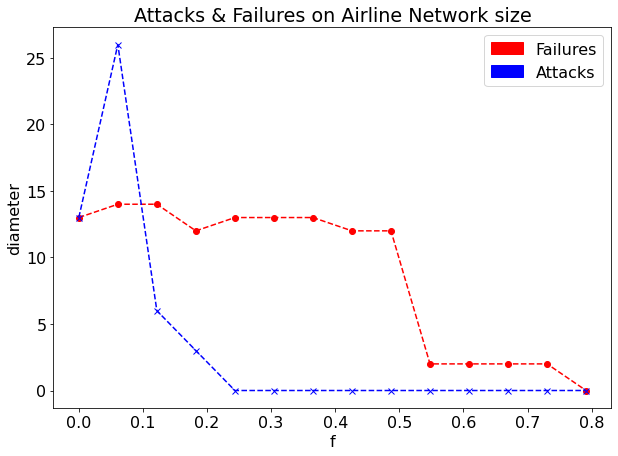

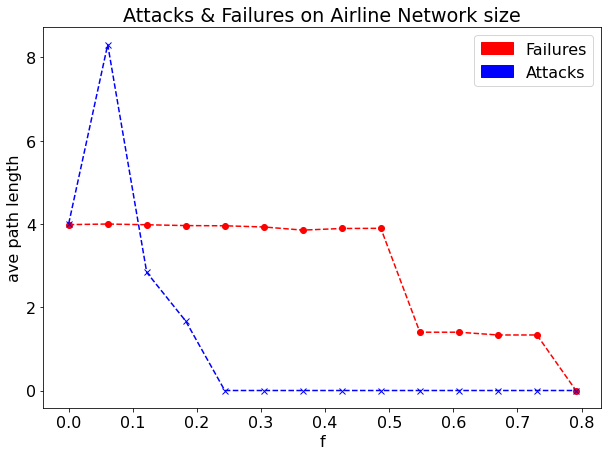

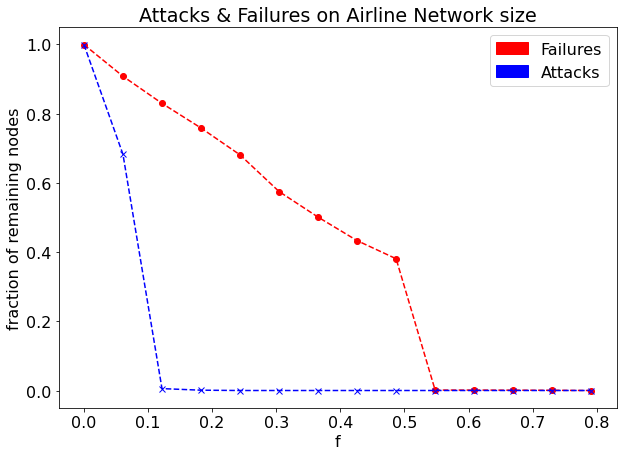

In [16]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 16, "figure.figsize": fig_size})
xvalues = [(float(x)/float(NetworkSize)) * 200 for x in range(len(anf_ave_diameters))]

# Plot diameter
plt.plot(xvalues, anf_ave_diameters, '--or', xvalues, ana_ave_diameters, '--xb')
plt.xlabel('f')
plt.ylabel('diameter')
plt.title('Attacks & Failures on Airline Network size')
red_patch = mpatches.Patch(color='red', label='Failures')
blue_patch = mpatches.Patch(color='blue', label='Attacks')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Plot average path length
plt.plot(xvalues, anf_ave_path_lengths, '--or', xvalues, ana_ave_path_lengths, '--xb')
red_patch = mpatches.Patch(color='red', label='Failures')
blue_patch = mpatches.Patch(color='blue', label='Attacks')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('ave path length')
plt.title('Attacks & Failures on Airline Network size')
plt.show()

# Plot fraction of nodes in giant component
plt.plot(xvalues, anf_ave_S, '--or', xvalues, ana_ave_S, '--xb')
red_patch = mpatches.Patch(color='red', label='Failures')
blue_patch = mpatches.Patch(color='blue', label='Attacks')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('fraction of remaining nodes')
plt.title('Attacks & Failures on Airline Network size')
plt.show()    


Airport networks are crucial for understanding the spread of world-wide pandemics. Air-travel is one of the quickest ways that diseases can spread across the globe. For the airport network, an attack is effectively the closure of an airport. In this scenario, it would be good to know if it is possible to break the network apart, and stop the disease spread, by only attacking a few nodes (closing a few airports).
<br>
<br> From the experiments, closing a few airports (with the most connectivity) would result in increase in diameter (i.e. shortest distance between two airports) and average path length (i.e. longest number of flights to reach anywhere in the world) within the airline network. These results are not surprising, as closing of a few airports would mean having to perform more transits (somewhere else).